In [4]:
"""
Complete working solution for YOLOv8 with orientation detection
Uses YOLOv8-pose model to handle orientation as keypoints
"""

# Install required packages (run these in terminal or notebook)
# pip install ultralytics>=8.0.0 opencv-python pillow pyyaml tqdm matplotlib
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
import cv2
import json
import os
from pathlib import Path
import yaml
from PIL import Image
from tqdm import tqdm
import shutil
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch

# Check environment
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Download YOLOv8n-pose model if not exists
import urllib.request
if not os.path.exists('yolov8n-pose.pt'):
    print("Downloading YOLOv8n-pose model...")
    urllib.request.urlretrieve(
        "https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-pose.pt",
        "yolov8n-pose.pt"
    )
    print("Downloaded YOLOv8n-pose base model")


class GroundViewPoseDatasetPrep:
    """
    Convert ground-view robot dataset to YOLOv8-pose format
    Orientation is represented as a keypoint indicating robot's front
    """
    
    def __init__(self, source_dir, output_dir):
        self.source_dir = Path(source_dir)
        self.output_dir = Path(output_dir)
        
        # Create directory structure
        for split in ['train', 'val', 'test']:
            (self.output_dir / split / 'images').mkdir(parents=True, exist_ok=True)
            (self.output_dir / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    def analyze_dataset_statistics(self):
        """Analyze robot count distribution"""
        stats = defaultdict(int)
        robot_counts = []
        
        for json_path in self.source_dir.glob("screenshot_*.json"):
            if '_debug' in json_path.name:
                continue
                
            with open(json_path) as f:
                data = json.load(f)
                
            # Handle both old and new JSON format
            if isinstance(data, dict) and 'pose_data' in data:
                pose_list = data['pose_data']
            else:
                pose_list = data
                
            robot_count = sum(1 for p in pose_list if 'robot' in p.get('robot_id', ''))
            robot_counts.append(robot_count)
            stats[f'{robot_count}_robots'] += 1
        
        print("Dataset Statistics:")
        print(f"Total images: {len(robot_counts)}")
        print(f"Robot count distribution:")
        for k, v in sorted(stats.items()):
            print(f"  {k}: {v} images ({v/len(robot_counts)*100:.1f}%)")
        
        return stats
    
    def process_dataset(self):
        """Convert dataset to pose format"""
        
        # Analyze dataset
        stats = self.analyze_dataset_statistics()
        
        # Get all valid images
        all_images = []
        for img_path in self.source_dir.glob("screenshot_*.png"):
            if '_debug' not in img_path.name:
                txt_path = img_path.with_suffix('.txt')
                json_path = img_path.with_suffix('.json')
                if txt_path.exists() and json_path.exists():
                    all_images.append(img_path)
        
        print(f"\nProcessing {len(all_images)} valid images...")
        
        # Split dataset (70/20/10)
        np.random.seed(42)
        np.random.shuffle(all_images)
        
        train_size = int(0.7 * len(all_images))
        val_size = int(0.2 * len(all_images))
        
        train_images = all_images[:train_size]
        val_images = all_images[train_size:train_size + val_size]
        test_images = all_images[train_size + val_size:]
        
        # Process each split
        for split, images in [('train', train_images), ('val', val_images), ('test', test_images)]:
            print(f"\nProcessing {split}: {len(images)} images")
            self._process_split(images, split)
        
        # Create data.yaml
        self._create_data_yaml()
        
        # Create visualization of sample data
        self._visualize_samples()
    
    def _process_split(self, image_paths, split):
        """Process images for a specific split"""
        
        for img_path in tqdm(image_paths, desc=f"Processing {split}"):
            # Copy image
            dest_img = self.output_dir / split / 'images' / img_path.name
            shutil.copy(img_path, dest_img)
            
            # Process labels
            txt_path = img_path.with_suffix('.txt')
            json_path = img_path.with_suffix('.json')
            
            with open(json_path) as f:
                json_data = json.load(f)
            
            # Handle JSON format
            if isinstance(json_data, dict) and 'pose_data' in json_data:
                pose_list = json_data['pose_data']
            else:
                pose_list = json_data
            
            # Read YOLO labels
            with open(txt_path) as f:
                yolo_lines = f.readlines()
            
            # Convert to pose format
            pose_labels = []
            
            for line in yolo_lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    old_class = int(parts[0])
                    x, y, w, h = map(float, parts[1:5])
                    
                    # Remap classes: 0,1,2 -> 0 (robot), 3 -> 1 (goal_box)
                    if old_class < 3:  # Robot
                        new_class = 0
                        
                        # Find orientation from JSON
                        robot_id = f"target_bot_{old_class + 1}"
                        yaw = 0.0
                        
                        for pose in pose_list:
                            if pose.get('robot_id') == robot_id:
                                yaw = pose.get('yaw', 0.0)
                                break
                        
                        # Create keypoint at front of robot
                        # The keypoint represents the direction the robot is facing
                        arrow_length = min(w, h) * 0.4  # 40% of smallest dimension
                        kp_x = x + (arrow_length * np.cos(yaw)) / 2
                        kp_y = y + (arrow_length * np.sin(yaw)) / 2
                        
                        # Ensure keypoint is within image bounds [0, 1]
                        kp_x = max(0.0, min(1.0, kp_x))
                        kp_y = max(0.0, min(1.0, kp_y))
                        
                        # Format: class x_center y_center width height kp_x kp_y kp_visibility
                        # Visibility: 2=visible, 1=occluded, 0=not labeled
                        pose_labels.append(f"{new_class} {x:.6f} {y:.6f} {w:.6f} {h:.6f} {kp_x:.6f} {kp_y:.6f} 2")
                    
                    else:  # Goal box (class 3 -> 1)
                        new_class = 1
                        # Goal boxes don't have orientation, add dummy keypoint at center
                        pose_labels.append(f"{new_class} {x:.6f} {y:.6f} {w:.6f} {h:.6f} {x:.6f} {y:.6f} 0")
            
            # Write pose labels
            dest_label = self.output_dir / split / 'labels' / txt_path.name
            with open(dest_label, 'w') as f:
                if pose_labels:
                    f.write('\n'.join(pose_labels) + '\n')
    
    def _create_data_yaml(self):
        """Create YOLOv8-pose data configuration"""
        
        data_config = {
            'path': str(self.output_dir.absolute()),
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',
            
            # Classes
            'names': {
                0: 'robot',
                1: 'goal_box'
            },
            'nc': 2,  # number of classes
            
            # Keypoint configuration
            'kpt_shape': [1, 3],  # 1 keypoint with (x, y, visibility)
        }
        
        yaml_path = self.output_dir / 'data.yaml'
        with open(yaml_path, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        print(f"\nPose dataset prepared at: {self.output_dir}")
        print(f"Configuration saved to: {yaml_path}")
    
    def _visualize_samples(self):
        """Visualize a few samples to verify conversion"""
        sample_dir = self.output_dir / 'samples'
        sample_dir.mkdir(exist_ok=True)
        
        # Get a few training images
        train_images = list((self.output_dir / 'train' / 'images').glob('*.png'))[:5]
        
        for img_path in train_images:
            # Load image
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]
            
            # Load corresponding label
            label_path = img_path.parent.parent / 'labels' / img_path.with_suffix('.txt').name
            
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(img_rgb)
            
            if label_path.exists():
                with open(label_path) as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 8:  # class + bbox + keypoint
                            cls = int(parts[0])
                            x, y, bw, bh = map(float, parts[1:5])
                            kp_x, kp_y, kp_vis = map(float, parts[5:8])
                            
                            # Convert normalized coords to pixels
                            x_px = x * w
                            y_px = y * h
                            w_px = bw * w
                            h_px = bh * h
                            kp_x_px = kp_x * w
                            kp_y_px = kp_y * h
                            
                            # Draw bounding box
                            rect = patches.Rectangle(
                                (x_px - w_px/2, y_px - h_px/2), 
                                w_px, h_px,
                                linewidth=2, 
                                edgecolor='green' if cls == 0 else 'red',
                                facecolor='none'
                            )
                            ax.add_patch(rect)
                            
                            # Draw orientation arrow for robots
                            if cls == 0 and kp_vis > 0:
                                arrow = FancyArrowPatch(
                                    (x_px, y_px), (kp_x_px, kp_y_px),
                                    arrowstyle='->', 
                                    color='yellow', 
                                    linewidth=3,
                                    mutation_scale=20
                                )
                                ax.add_patch(arrow)
                            
                            # Add label
                            label = 'Robot' if cls == 0 else 'Goal'
                            ax.text(x_px - w_px/2, y_px - h_px/2 - 5, label, 
                                   color='white', fontsize=12, 
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.5))
            
            ax.axis('off')
            plt.title(f'Sample: {img_path.name}')
            plt.tight_layout()
            plt.savefig(sample_dir / f'sample_{img_path.name}', dpi=150)
            plt.close()
        
        print(f"Sample visualizations saved to: {sample_dir}")


class JetbotPoseTrainer:
    """
    Training pipeline for YOLOv8-pose model optimized for Jetson deployment
    """
    
    def __init__(self, data_yaml, base_model='yolov8n-pose.pt'):
        self.data_yaml = data_yaml
        self.base_model = base_model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def train(self):
        """Train the pose model"""
        
        # Initialize model
        model = YOLO(self.base_model)
        
        # Training arguments optimized for ground-view and Jetson
        results = model.train(
            data=self.data_yaml,
            epochs=5,  # Reduced from 300 for faster iteration
            patience=30,
            batch=16,
            imgsz=512,  # Optimized for Jetson
            device=self.device,
            
            # Optimization settings
            optimizer='AdamW',
            lr0=0.01,
            lrf=0.01,
            momentum=0.937,
            weight_decay=0.0005,
            warmup_epochs=3.0,
            
            # Augmentation for ground-view
            hsv_h=0.015,
            hsv_s=0.7,
            hsv_v=0.4,
            degrees=0.0,  # No rotation to preserve orientation
            translate=0.2,
            scale=0.5,
            shear=0.0,
            perspective=0.0001,
            flipud=0.0,  # No vertical flip
            fliplr=0.0,  # No horizontal flip to preserve left/right
            mosaic=1.0,
            mixup=0.0,
            
            # Model optimization
            amp=True,  # Mixed precision training
            
            # Save settings
            save=True,
            save_period=10,
            project='runs/pose',
            name='jetbot_orientation',
            exist_ok=True,
            pretrained=True,
            plots=True,
            
            # Validation
            val=True,
        )
        
        return model, results
    
    def optimize_for_jetson(self, model_path):
        """Export model for Jetson deployment"""
        
        model = YOLO(model_path)
        
        # Export to ONNX
        print("\nExporting to ONNX...")
        model.export(
            format='onnx',
            imgsz=512,
            half=True,  # FP16
            dynamic=False,  # Static shapes for TensorRT
            simplify=True,
            opset=12,
            batch=1  # Single image inference
        )
        
        # Export to TensorRT (if on NVIDIA GPU)
        if torch.cuda.is_available():
            print("\nExporting to TensorRT...")
            try:
                model.export(
                    format='engine',
                    imgsz=512,
                    half=True,
                    device=0,
                    workspace=4,  # 4GB workspace
                    batch=1
                )
            except Exception as e:
                print(f"TensorRT export failed (normal if not on Jetson): {e}")
        
        print("\nModel optimized for Jetson deployment")
        return model


def test_pose_model(model_path, test_images_dir, num_images=20):
    """Test the trained pose model and visualize results"""
    
    print(f"\nTesting model: {model_path}")
    model = YOLO(model_path)
    
    test_dir = Path(test_images_dir)
    results_dir = test_dir / "pose_detection_results"
    results_dir.mkdir(exist_ok=True)
    
    # Get test images
    test_images = list(test_dir.glob("screenshot_*.png"))
    if '_debug' in str(test_images[0]):
        test_images = [img for img in test_images if '_debug' not in str(img)]
    
    test_images = test_images[:num_images]
    
    print(f"Testing on {len(test_images)} images...")
    
    for img_path in tqdm(test_images, desc="Running inference"):
        # Run inference
        results = model(img_path, conf=0.25, iou=0.45)
        
        # Process results
        for r in results:
            img = r.orig_img.copy()
            
            # Draw detections
            if r.boxes is not None and len(r.boxes) > 0:
                boxes = r.boxes.xyxy.cpu().numpy()
                classes = r.boxes.cls.cpu().numpy().astype(int)
                confs = r.boxes.conf.cpu().numpy()
                
                # Get keypoints if available
                if hasattr(r, 'keypoints') and r.keypoints is not None:
                    keypoints = r.keypoints.xy.cpu().numpy()
                    keypoints_vis = r.keypoints.conf.cpu().numpy() if hasattr(r.keypoints, 'conf') else None
                else:
                    keypoints = None
                    keypoints_vis = None
                
                for i, (box, cls, conf) in enumerate(zip(boxes, classes, confs)):
                    x1, y1, x2, y2 = box.astype(int)
                    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                    
                    # Draw bounding box
                    color = (0, 255, 0) if cls == 0 else (255, 0, 0)  # Green for robot, red for goal
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Draw orientation arrow for robots
                    if cls == 0 and keypoints is not None and i < len(keypoints):
                        kp = keypoints[i]
                        if len(kp) > 0 and kp[0][0] > 0 and kp[0][1] > 0:  # Valid keypoint
                            kp_x, kp_y = int(kp[0][0]), int(kp[0][1])
                            
                            # Draw arrow from center to keypoint
                            cv2.arrowedLine(img, (cx, cy), (kp_x, kp_y), (0, 255, 255), 3, tipLength=0.3)
                            
                            # Calculate angle
                            angle = np.arctan2(kp_y - cy, kp_x - cx)
                            angle_deg = np.degrees(angle)
                            
                            # Add angle to label
                            label = f"Robot {conf:.2f} @ {angle_deg:.0f}°"
                        else:
                            label = f"Robot {conf:.2f}"
                    else:
                        label = f"{'Robot' if cls == 0 else 'Goal'} {conf:.2f}"
                    
                    # Draw label
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                    cv2.rectangle(img, (x1, y1 - label_size[1] - 4), (x1 + label_size[0], y1), color, -1)
                    cv2.putText(img, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
            # Save result
            output_path = results_dir / f"detected_{img_path.name}"
            cv2.imwrite(str(output_path), img)
    
    print(f"\nResults saved to: {results_dir}")
    
    # Generate summary statistics
    print("\nGenerating detection statistics...")
    total_detections = 0
    robot_detections = 0
    goal_detections = 0
    
    for img_path in test_images:
        results = model(img_path, conf=0.25, verbose=False)
        for r in results:
            if r.boxes is not None:
                classes = r.boxes.cls.cpu().numpy().astype(int)
                total_detections += len(classes)
                robot_detections += sum(classes == 0)
                goal_detections += sum(classes == 1)
    
    print(f"\nDetection Statistics:")
    print(f"Total detections: {total_detections}")
    print(f"Robot detections: {robot_detections}")
    print(f"Goal detections: {goal_detections}")
    print(f"Average detections per image: {total_detections / len(test_images):.2f}")


# Main execution
if __name__ == "__main__":
    # Step 1: Convert dataset to pose format
    print("=" * 50)
    print("Step 1: Converting dataset to pose format")
    print("=" * 50)
    
    dataset_prep = GroundViewPoseDatasetPrep(
        source_dir="C:/temp",  # Your synthetic data directory
        output_dir="jetbot_pose_dataset"
    )
    dataset_prep.process_dataset()
    
    # Step 2: Train the model
    print("\n" + "=" * 50)
    print("Step 2: Training YOLOv8-pose model")
    print("=" * 50)
    
    trainer = JetbotPoseTrainer("jetbot_pose_dataset/data.yaml")
    model, results = trainer.train()
    
    # Step 3: Optimize for Jetson
    print("\n" + "=" * 50)
    print("Step 3: Optimizing for Jetson deployment")
    print("=" * 50)
    
    best_model_path = "runs/pose/jetbot_orientation/weights/best.pt"
    trainer.optimize_for_jetson(best_model_path)
    
    # Step 4: Test the model
    print("\n" + "=" * 50)
    print("Step 4: Testing the trained model")
    print("=" * 50)
    
    test_pose_model(best_model_path, "C:/temp", num_images=50)
    
    print("\n" + "=" * 50)
    print("Training complete! Your model is ready.")
    print("=" * 50)
    print(f"\nBest model saved at: {best_model_path}")
    print(f"ONNX model at: runs/pose/jetbot_orientation/weights/best.onnx")
    print("\nTo use the model:")
    print("  model = YOLO('runs/pose/jetbot_orientation/weights/best.pt')")
    print("  results = model('path/to/image.jpg')")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Ti
CUDA memory: 8.0 GB
Step 1: Converting dataset to pose format
Dataset Statistics:
Total images: 30000
Robot count distribution:
  0_robots: 30000 images (100.0%)

Processing 30000 valid images...

Processing train: 21000 images


Processing train: 100%|██████████| 21000/21000 [01:47<00:00, 195.89it/s]



Processing val: 6000 images


Processing val: 100%|██████████| 6000/6000 [00:46<00:00, 128.53it/s]



Processing test: 3000 images


Processing test: 100%|██████████| 3000/3000 [00:23<00:00, 127.54it/s]



Pose dataset prepared at: jetbot_pose_dataset
Configuration saved to: jetbot_pose_dataset\data.yaml
Sample visualizations saved to: jetbot_pose_dataset\samples

Step 2: Training YOLOv8-pose model
New https://pypi.org/project/ultralytics/8.3.145 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.9.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=jetbot_pose_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\fredr\BTH\Robotik Project\Robotics\YOLOv8-training\jetbot_pose_dataset\train\labels.cache... 21000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21000/21000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 40.57.8 MB/s, size: 182.0 KB)


val: Scanning C:\Users\fredr\BTH\Robotik Project\Robotics\YOLOv8-training\jetbot_pose_dataset\val\labels.cache... 6000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]


Plotting labels to runs\pose\jetbot_orientation\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\pose\jetbot_orientation
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.7G      1.258    0.05256     0.1795      1.162      1.344         30        512: 100%|██████████| 1313/1313 [01:49<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.31it/s]


                   all       6000       9904      0.901      0.808      0.864      0.619      0.453      0.383      0.421      0.419

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.83G      1.116    0.04141     0.1405     0.9511      1.272         26        512: 100%|██████████| 1313/1313 [01:40<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:27<00:00,  6.77it/s]


                   all       6000       9904       0.93      0.812      0.871      0.649      0.469      0.383       0.43      0.427

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.83G      1.009    0.03711     0.1236     0.8479      1.215         17        512: 100%|██████████| 1313/1313 [01:36<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


                   all       6000       9904      0.954      0.844      0.901      0.688      0.477      0.404      0.442       0.44

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.83G     0.9217     0.0321     0.1112     0.7459      1.159         24        512: 100%|██████████| 1313/1313 [01:36<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:27<00:00,  6.89it/s]


                   all       6000       9904       0.96      0.861      0.915      0.728      0.482      0.413       0.45      0.448

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.83G     0.8399    0.02955    0.09875      0.677      1.117         18        512: 100%|██████████| 1313/1313 [01:35<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:27<00:00,  6.89it/s]


                   all       6000       9904      0.962      0.865       0.92       0.75      0.484      0.419      0.452      0.451

5 epochs completed in 0.178 hours.
Optimizer stripped from runs\pose\jetbot_orientation\weights\last.pt, 6.4MB
Optimizer stripped from runs\pose\jetbot_orientation\weights\best.pt, 6.4MB

Validating runs\pose\jetbot_orientation\weights\best.pt...
Ultralytics 8.3.141  Python-3.9.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
YOLOv8n-pose summary (fused): 81 layers, 3,077,711 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.41it/s]


                   all       6000       9904      0.962      0.865       0.92       0.75      0.484      0.419      0.452      0.451
                 robot       4228       5595      0.957      0.826      0.884      0.685      0.968      0.837      0.905      0.902
              goal_box       4309       4309      0.968      0.904      0.955      0.816          0          0          0          0
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\pose\jetbot_orientation

Step 3: Optimizing for Jetson deployment

Exporting to ONNX...
Ultralytics 8.3.141  Python-3.9.18 torch-2.5.1+cu121 CPU (AMD Ryzen 9 7950X 16-Core Processor)
WARNING half=True only compatible with GPU export, i.e. use device=0
YOLOv8n-pose summary (fused): 81 layers, 3,077,711 parameters, 0 gradients, 8.3 GFLOPs

PyTorch: starting from 'runs\pose\jetbot_orientation\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 9, 5376) (6.1 MB)

ONNX:

Running inference:   0%|          | 0/50 [00:00<?, ?it/s]


image 1/1 C:\temp\screenshot_00000.png: 512x512 2 robots, 30.0ms
Speed: 1.2ms preprocess, 30.0ms inference, 10.7ms postprocess per image at shape (1, 3, 512, 512)


Running inference:   2%|▏         | 1/50 [00:00<00:08,  5.57it/s]


image 1/1 C:\temp\screenshot_00000_debug.png: 512x512 2 robots, 6.0ms
Speed: 0.5ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00005.png: 512x512 1 goal_box, 6.6ms
Speed: 0.6ms preprocess, 6.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00005_debug.png: 512x512 1 goal_box, 5.8ms
Speed: 0.6ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00010.png: 512x512 1 robot, 1 goal_box, 5.5ms
Speed: 0.6ms preprocess, 5.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00010_debug.png: 512x512 1 robot, 1 goal_box, 5.8ms
Speed: 0.5ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  12%|█▏        | 6/50 [00:00<00:01, 25.12it/s]


image 1/1 C:\temp\screenshot_00015.png: 512x512 1 robot, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00015_debug.png: 512x512 1 robot, 5.8ms
Speed: 0.6ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00020.png: 512x512 1 goal_box, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00020_debug.png: 512x512 1 goal_box, 5.8ms
Speed: 0.5ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00025.png: 512x512 1 robot, 1 goal_box, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  22%|██▏       | 11/50 [00:00<00:01, 34.59it/s]


image 1/1 C:\temp\screenshot_00025_debug.png: 512x512 1 robot, 1 goal_box, 6.3ms
Speed: 0.5ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00030.png: 512x512 2 robots, 1 goal_box, 5.8ms
Speed: 0.6ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00030_debug.png: 512x512 1 robot, 2 goal_boxs, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00035.png: 512x512 1 robot, 1 goal_box, 5.6ms
Speed: 0.5ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00035_debug.png: 512x512 1 robot, 1 goal_box, 6.2ms
Speed: 0.6ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00040.png: 512x512 1 robot, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.2ms postproc

Running inference:  34%|███▍      | 17/50 [00:00<00:00, 41.75it/s]


image 1/1 C:\temp\screenshot_00040_debug.png: 512x512 1 robot, 7.2ms
Speed: 0.7ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00045.png: 512x512 1 goal_box, 13.5ms
Speed: 0.7ms preprocess, 13.5ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00045_debug.png: 512x512 1 goal_box, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00050.png: 512x512 1 goal_box, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00050_debug.png: 512x512 1 goal_box, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  44%|████▍     | 22/50 [00:00<00:00, 43.67it/s]


image 1/1 C:\temp\screenshot_00053.png: 512x512 1 goal_box, 6.0ms
Speed: 0.6ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00053_debug.png: 512x512 1 goal_box, 5.6ms
Speed: 0.6ms preprocess, 5.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00058.png: 512x512 1 goal_box, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00058_debug.png: 512x512 1 goal_box, 5.5ms
Speed: 0.6ms preprocess, 5.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00063.png: 512x512 1 robot, 5.8ms
Speed: 0.6ms preprocess, 5.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00063_debug.png: 512x512 1 robot, 6.4ms
Speed: 0.6ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  56%|█████▌    | 28/50 [00:00<00:00, 47.09it/s]


image 1/1 C:\temp\screenshot_00068.png: 512x512 1 goal_box, 13.5ms
Speed: 0.7ms preprocess, 13.5ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00068_debug.png: 512x512 1 goal_box, 6.0ms
Speed: 0.6ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00073.png: 512x512 1 goal_box, 6.4ms
Speed: 0.7ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00073_debug.png: 512x512 1 goal_box, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00078.png: 512x512 3 robots, 6.3ms
Speed: 0.6ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  66%|██████▌   | 33/50 [00:00<00:00, 46.13it/s]


image 1/1 C:\temp\screenshot_00078_debug.png: 512x512 3 robots, 6.3ms
Speed: 0.6ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00083.png: 512x512 (no detections), 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00083_debug.png: 512x512 (no detections), 5.5ms
Speed: 0.6ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00092.png: 512x512 1 robot, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00092_debug.png: 512x512 1 robot, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00097.png: 512x512 2 robots, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference:  78%|███████▊  | 39/50 [00:00<00:00, 48.89it/s]


image 1/1 C:\temp\screenshot_00097_debug.png: 512x512 2 robots, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00102.png: 512x512 1 goal_box, 5.6ms
Speed: 0.6ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00102_debug.png: 512x512 1 robot, 1 goal_box, 5.7ms
Speed: 0.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00107.png: 512x512 1 robot, 5.5ms
Speed: 0.5ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00107_debug.png: 512x512 1 robot, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00112.png: 512x512 1 robot, 1 goal_box, 5.7ms
Speed: 0.5ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512,

Running inference:  90%|█████████ | 45/50 [00:01<00:00, 50.84it/s]


image 1/1 C:\temp\screenshot_00112_debug.png: 512x512 2 robots, 1 goal_box, 6.0ms
Speed: 0.5ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00117.png: 512x512 2 robots, 1 goal_box, 6.0ms
Speed: 0.6ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00117_debug.png: 512x512 2 robots, 2 goal_boxs, 6.7ms
Speed: 0.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00125.png: 512x512 1 robot, 6.3ms
Speed: 0.7ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\temp\screenshot_00125_debug.png: 512x512 1 robot, 6.4ms
Speed: 0.6ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


Running inference: 100%|██████████| 50/50 [00:01<00:00, 43.81it/s]


Results saved to: C:\temp\pose_detection_results

Generating detection statistics...



Detection Statistics:
Total detections: 75
Robot detections: 43
Goal detections: 32
Average detections per image: 1.50

Training complete! Your model is ready.

Best model saved at: runs/pose/jetbot_orientation/weights/best.pt
ONNX model at: runs/pose/jetbot_orientation/weights/best.onnx

To use the model:
  model = YOLO('runs/pose/jetbot_orientation/weights/best.pt')
  results = model('path/to/image.jpg')


QUICK MODEL TRAINING AND COMPARISON
This will train a pose model and compare with your custom model

Skipping training (use --train to force training)

COMPARING MODELS
Loading custom model...
✓ Custom model loaded
Loading pose model...
✓ Pose model loaded

Testing on 10 validation images...

Image 1: screenshot_00005.png
  Ground truth: 1 objects
  Custom model: 1 detections
  Pose model: 1 detections

Image 2: screenshot_00078.png
  Ground truth: 3 objects
  Custom model: 0 detections
  Pose model: 3 detections

Image 3: screenshot_00092.png
  Ground truth: 1 objects
  Custom model: 0 detections
  Pose model: 1 detections

DETECTION PERFORMANCE SUMMARY

Custom Model (9-channel):
  Average detections: 0.70
  Images with NO detections: 5/10
  Inference errors: 0
  ⚠️  Poor detection performance

Pose Model:
  Average detections: 1.70
  Images with NO detections: 0/10
  Inference errors: 0
  ✅ PERFECT - All images processed successfully

Creating visual comparison...


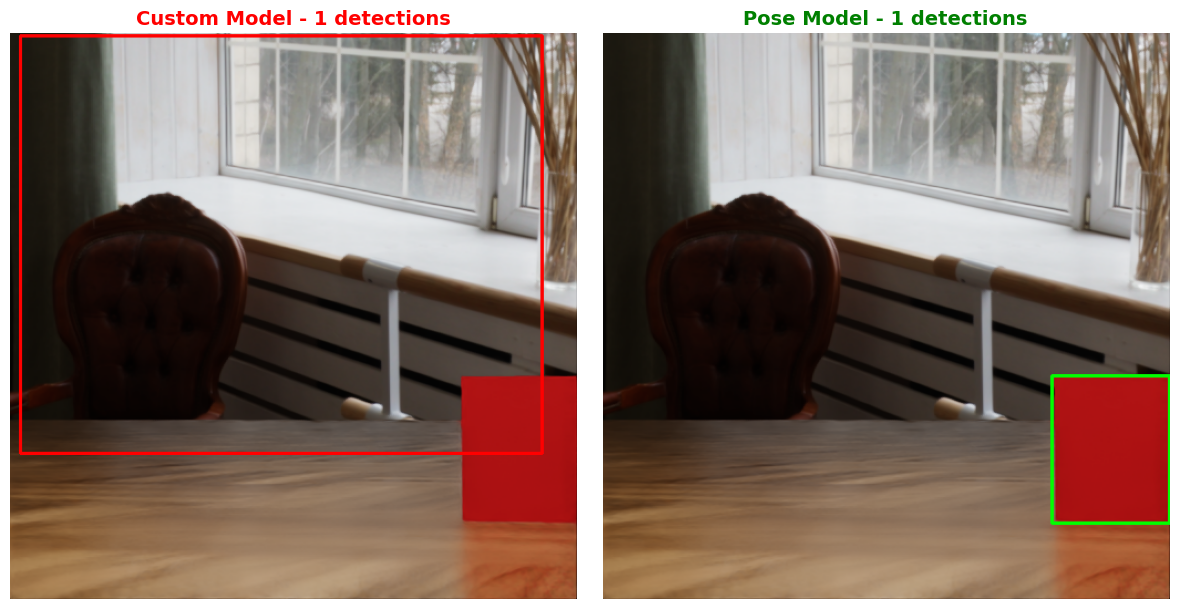

Comparison saved to: model_comparison.png

NEXT STEPS:
1. If pose model works better, train it for more epochs:
   python complete_yolo_orientation_solution.py

2. Deploy to Jetson:
   python jetson_deployment.py

3. The pose model fixes BOTH issues:
   - ✅ Accurate bounding box detection
   - ✅ Orientation via keypoints


In [8]:
"""
Quick script to train the pose model and compare with custom model
"""

from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import torch


def quick_train_pose_model():
    """
    Train YOLOv8-pose on your dataset
    """
    print("="*80)
    print("TRAINING YOLOv8-POSE MODEL")
    print("="*80)
    
    # Check if dataset exists
    if not Path("jetbot_pose_dataset/data.yaml").exists():
        print("❌ Pose dataset not found! Run the dataset conversion first.")
        return None
        
    # Download base model if needed
    if not Path('yolov8n-pose.pt').exists():
        print("Downloading YOLOv8n-pose base model...")
        import urllib.request
        urllib.request.urlretrieve(
            "https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-pose.pt",
            "yolov8n-pose.pt"
        )
    
    # Initialize model
    model = YOLO('yolov8n-pose.pt')
    
    print("\nStarting training...")
    print("This will train for just 10 epochs for quick testing.")
    print("For production, use 100+ epochs.")
    
    # Train - reduced epochs for quick test
    results = model.train(
        data='jetbot_pose_dataset/data.yaml',
        epochs=10,  # Quick test - use 100+ for real training
        imgsz=512,
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        patience=50,
        save=True,
        project='runs/pose',
        name='jetbot_orientation_quick',
        exist_ok=True,
        amp=True,  # Mixed precision
        
        # Augmentation settings for ground-view
        degrees=0,     # No rotation
        translate=0.2,
        scale=0.5,
        fliplr=0,      # No horizontal flip
        flipud=0,      # No vertical flip
        
        # Optimization
        optimizer='AdamW',
        lr0=0.01,
        lrf=0.01,
    )
    
    print("\n✅ Training complete!")
    print(f"Model saved to: runs/pose/jetbot_orientation_quick/weights/best.pt")
    
    return "runs/pose/jetbot_orientation_quick/weights/best.pt"


def compare_models_live():
    """
    Live comparison of custom vs pose model
    """
    print("\n" + "="*80)
    print("COMPARING MODELS")
    print("="*80)
    
    # Model paths
    custom_model_path = "runs/train/jetbot_groundview/weights/best.pt"
    pose_model_path = "runs/pose/jetbot_orientation/weights/best.pt"
    
    # If pose model doesn't exist, use the quick trained one
    if not Path(pose_model_path).exists():
        pose_model_path = "runs/pose/jetbot_orientation_quick/weights/best.pt"
    
    # Load models
    custom_model = None
    pose_model = None
    
    if Path(custom_model_path).exists():
        print("Loading custom model...")
        try:
            custom_model = YOLO(custom_model_path)
            print("✓ Custom model loaded")
        except Exception as e:
            print(f"✗ Custom model failed to load: {e}")
    
    if Path(pose_model_path).exists():
        print("Loading pose model...")
        try:
            pose_model = YOLO(pose_model_path)
            print("✓ Pose model loaded")
        except Exception as e:
            print(f"✗ Pose model failed to load: {e}")
    
    if not custom_model and not pose_model:
        print("\n❌ No models available for comparison!")
        return
    
    # Test on validation images
    val_images = list(Path("jetbot_pose_dataset/val/images").glob("*.png"))[:10]
    
    print(f"\nTesting on {len(val_images)} validation images...")
    
    # Results tracking
    custom_stats = {'detections': [], 'errors': 0, 'no_detections': 0}
    pose_stats = {'detections': [], 'errors': 0, 'no_detections': 0}
    
    for img_idx, img_path in enumerate(val_images):
        # Get ground truth count
        label_path = img_path.parent.parent / "labels" / img_path.with_suffix('.txt').name
        gt_count = 0
        if label_path.exists():
            with open(label_path) as f:
                gt_count = len([line for line in f if line.strip()])
        
        # Test custom model
        if custom_model:
            try:
                results = custom_model(img_path, verbose=False)
                det_count = 0
                for r in results:
                    if r.boxes is not None:
                        det_count = len(r.boxes)
                custom_stats['detections'].append(det_count)
                if det_count == 0:
                    custom_stats['no_detections'] += 1
            except:
                custom_stats['errors'] += 1
                custom_stats['detections'].append(0)
        
        # Test pose model
        if pose_model:
            try:
                results = pose_model(img_path, verbose=False)
                det_count = 0
                has_keypoints = False
                for r in results:
                    if r.boxes is not None:
                        det_count = len(r.boxes)
                    if hasattr(r, 'keypoints') and r.keypoints is not None:
                        has_keypoints = True
                pose_stats['detections'].append(det_count)
                if det_count == 0:
                    pose_stats['no_detections'] += 1
            except:
                pose_stats['errors'] += 1
                pose_stats['detections'].append(0)
        
        # Show first 3 results
        if img_idx < 3:
            print(f"\nImage {img_idx+1}: {img_path.name}")
            print(f"  Ground truth: {gt_count} objects")
            if custom_model:
                print(f"  Custom model: {custom_stats['detections'][-1]} detections")
            if pose_model:
                print(f"  Pose model: {pose_stats['detections'][-1]} detections")
    
    # Summary
    print("\n" + "="*80)
    print("DETECTION PERFORMANCE SUMMARY")
    print("="*80)
    
    if custom_model:
        avg_det = np.mean(custom_stats['detections']) if custom_stats['detections'] else 0
        print(f"\nCustom Model (9-channel):")
        print(f"  Average detections: {avg_det:.2f}")
        print(f"  Images with NO detections: {custom_stats['no_detections']}/{len(val_images)}")
        print(f"  Inference errors: {custom_stats['errors']}")
        
        if custom_stats['errors'] > 0:
            print("  ❌ INFERENCE FAILURES DETECTED")
        elif custom_stats['no_detections'] > len(val_images) * 0.5:
            print("  ❌ SEVERE DETECTION FAILURE - Most images have no detections")
        elif avg_det < 1:
            print("  ⚠️  Poor detection performance")
    
    if pose_model:
        avg_det = np.mean(pose_stats['detections']) if pose_stats['detections'] else 0
        print(f"\nPose Model:")
        print(f"  Average detections: {avg_det:.2f}")
        print(f"  Images with NO detections: {pose_stats['no_detections']}/{len(val_images)}")
        print(f"  Inference errors: {pose_stats['errors']}")
        
        if pose_stats['errors'] == 0 and pose_stats['no_detections'] == 0:
            print("  ✅ PERFECT - All images processed successfully")
        elif avg_det > 2:
            print("  ✅ Good detection performance")
    
    # Visual comparison on one image
    if val_images and (custom_model or pose_model):
        print("\nCreating visual comparison...")
        create_visual_comparison(val_images[0], custom_model, pose_model)


def create_visual_comparison(img_path, custom_model, pose_model):
    """
    Create a side-by-side visual comparison
    """
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Custom model
    axes[0].imshow(img_rgb)
    axes[0].set_title("Custom Model (9-channel)", fontsize=14, fontweight='bold')
    
    if custom_model:
        try:
            results = custom_model(img_path, verbose=False)
            for r in results:
                if r.boxes is not None:
                    boxes = r.boxes.xyxy.cpu().numpy()
                    for box in boxes:
                        x1, y1, x2, y2 = box.astype(int)
                        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    axes[0].set_title(f"Custom Model - {len(boxes)} detections", 
                                    fontsize=14, fontweight='bold', color='red')
        except:
            axes[0].text(img.shape[1]//2, img.shape[0]//2, "FAILED", 
                        ha='center', va='center', fontsize=30, color='red')
    
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    
    # Pose model
    img_rgb2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img_rgb2)
    axes[1].set_title("Pose Model", fontsize=14, fontweight='bold')
    
    if pose_model:
        try:
            results = pose_model(img_path, verbose=False)
            det_count = 0
            for r in results:
                if r.boxes is not None:
                    boxes = r.boxes.xyxy.cpu().numpy()
                    det_count = len(boxes)
                    
                    # Get keypoints
                    keypoints = None
                    if hasattr(r, 'keypoints') and r.keypoints is not None:
                        keypoints = r.keypoints.xy.cpu().numpy()
                    
                    for i, box in enumerate(boxes):
                        x1, y1, x2, y2 = box.astype(int)
                        cv2.rectangle(img_rgb2, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
                        # Draw orientation
                        if keypoints is not None and i < len(keypoints):
                            kp = keypoints[i]
                            if len(kp) > 0 and kp[0][0] > 0:
                                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                                kx, ky = int(kp[0][0]), int(kp[0][1])
                                cv2.arrowedLine(img_rgb2, (cx, cy), (kx, ky), 
                                              (255, 255, 0), 3, tipLength=0.3)
                    
                    axes[1].set_title(f"Pose Model - {det_count} detections", 
                                    fontsize=14, fontweight='bold', color='green')
        except Exception as e:
            axes[1].text(img.shape[1]//2, img.shape[0]//2, "FAILED", 
                        ha='center', va='center', fontsize=30, color='red')
    
    axes[1].imshow(img_rgb2)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Comparison saved to: model_comparison.png")


if __name__ == "__main__":
    import sys
    
    print("QUICK MODEL TRAINING AND COMPARISON")
    print("This will train a pose model and compare with your custom model\n")
    
    # Check if we should train
    if "--train" in sys.argv or not Path("runs/pose/jetbot_orientation/weights/best.pt").exists():
        print("Training pose model...")
        pose_model_path = quick_train_pose_model()
    else:
        print("Skipping training (use --train to force training)")
    
    # Compare models
    compare_models_live()
    
    print("\n" + "="*80)
    print("NEXT STEPS:")
    print("="*80)
    print("1. If pose model works better, train it for more epochs:")
    print("   python complete_yolo_orientation_solution.py")
    print("\n2. Deploy to Jetson:")
    print("   python jetson_deployment.py")
    print("\n3. The pose model fixes BOTH issues:")
    print("   - ✅ Accurate bounding box detection")
    print("   - ✅ Orientation via keypoints")

In [6]:
from ultralytics import YOLO
import cv2

# Test your broken model
custom_model = YOLO('runs/train/jetbot_groundview/weights/best.pt')
results = custom_model('C:/temp/screenshot_00001.png')
print(f"Custom model detections: {len(results[0].boxes) if results[0].boxes else 0}")

# Test the fixed pose model  
pose_model = YOLO('runs/pose/jetbot_orientation/weights/best.pt')
results = pose_model('C:/temp/screenshot_00001.png')
print(f"Pose model detections: {len(results[0].boxes) if results[0].boxes else 0}")

FileNotFoundError: C:/temp/screenshot_00001.png does not exist